In [244]:
#!/usr/bin/env python3

import pickle as pk
import sys
import time as tm
from argparse import ArgumentParser

import matplotlib.pyplot as plt
import numpy as np
import scipy as sc
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from captum.attr import FeatureAblation
from sklearn.metrics import mean_squared_error, r2_score
from torch.utils.data.dataset import Dataset

sns.set_theme()

batch_size = 30
num_workers = 10

In [245]:
p_latent_space = 15
num_epochs = 25

In [246]:


class dataset_pheno(Dataset):
    """a class for importing phenotype data.
    It expects a pickled object that is organized as a list of tensors:
    genotypes[n_animals, n_loci, n_alleles] (one hot at allelic state)
    gen_locs[n_animals, n_loci] (index of allelic state)
    weights[n_phens, n_loci, n_alleles] float weight for allelic contribution to phen
    phens[n_animals,n_phens] float value for phenotype
    indexes_of_loci_influencing_phen[n_phens,n_loci_ip] integer indicies of loci that influence a phenotype
    interaction_matrix[FILL THIS IN]
    pleiotropy_matrix[n_phens, n_phens, gen_index]"""

    def __init__(self, data_file, n_phens):
        self.datset = pk.load(open(data_file, "rb"))
        self.phens = torch.tensor(np.array(self.datset["phenotypes"]), dtype=torch.float32)
        self.data_file = data_file
        self.n_phens = n_phens

    def __len__(self):
        return len(self.phens)

    def __getitem__(self, idx):
        phenotypes = self.phens[idx][: self.n_phens]
        return phenotypes


In [247]:

#train_data_pheno = dataset_pheno('arapheno_scaled_study3_4_5_lowNA_pheno.pk', n_phens=25)
#test_data_pheno = dataset_pheno('arapheno_scaled_study3_4_5_highNA_pheno.pk', n_phens=25)

train_data_pheno = dataset_pheno('arapheno_scaled_study3_4_5_lowNA_pheno_train.pk', n_phens=25)
test_data_pheno = dataset_pheno('arapheno_scaled_study3_4_5_lowNA_pheno_test.pk', n_phens=25)


In [248]:
# setting device on GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

train_loader_pheno = torch.utils.data.DataLoader(
    dataset=train_data_pheno, batch_size=batch_size, num_workers=num_workers, shuffle=True
)
test_loader_pheno = torch.utils.data.DataLoader(
    dataset=test_data_pheno, batch_size=batch_size, num_workers=num_workers, shuffle=True
)

# how many samples per batch to load


Using device: cuda


/opt/conda/envs/gpatlas/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [249]:

# encoder
class Q_net(nn.Module):
    def __init__(self, phen_dim=None, N=None):
        super().__init__()
        if N is None:
            N = p_latent_space
        if phen_dim is None:
            phen_dim = 25

        batchnorm_momentum = 0.8
        latent_dim = p_latent_space
        self.encoder = nn.Sequential(
            nn.Linear(in_features=phen_dim, out_features=N),
            nn.BatchNorm1d(N, momentum=batchnorm_momentum),
            nn.LeakyReLU(0.01, inplace=True),
            nn.Linear(in_features=N, out_features=latent_dim),
            nn.BatchNorm1d(latent_dim, momentum=batchnorm_momentum),
            nn.LeakyReLU(0.01, inplace=True),
        )

    def forward(self, x):
        x = self.encoder(x)
        return x


# decoder
class P_net(nn.Module):
    def __init__(self, phen_dim=None, N=None):
        if N is None:
            N = p_latent_space
        if phen_dim is None:
            phen_dim = 25

        out_phen_dim = 25
        #vabs.n_locs * vabs.n_alleles
        latent_dim = p_latent_space

        batchnorm_momentum = 0.8

        super().__init__()
        self.decoder = nn.Sequential(
            nn.Linear(in_features=latent_dim, out_features=N),
            nn.BatchNorm1d(N, momentum=batchnorm_momentum),
            nn.LeakyReLU(0.01),
            nn.Linear(in_features=N, out_features=out_phen_dim),
        )

    def forward(self, x):
        x = self.decoder(x)
        return x


In [250]:
# set minimum variable
EPS = 1e-15
reg_lr = 0.001
adam_b = (0.5, 0.999)


# initialize all networks
Q = Q_net()
P = P_net()

Q.to(device)
P.to(device)

optim_P = torch.optim.Adam(P.parameters(), lr=reg_lr, betas=adam_b)
optim_Q_enc = torch.optim.Adam(Q.parameters(), lr=reg_lr, betas=adam_b)

In [251]:

# train phen autoencoder
n_phens = 25
n_phens_pred = 25
rcon_loss = []

start_time = tm.time()

for n in range(num_epochs):
    for i, (phens) in enumerate(train_loader_pheno):
        phens = phens[:, :n_phens]
        #print(phens)
        phens = phens.to(device)  # move data to GPU if it is there
        batch_size = phens.shape[0]  # redefine batch size here to allow for incomplete batches

        # reconstruction loss
        Q.zero_grad()
        P.zero_grad()

        noise_phens = phens + (0.001**0.5) * torch.randn(phens.shape).to(device)

        z_sample = Q(noise_phens)
        X_sample = P(z_sample)

        # recon_loss = F.mse_loss(X_sample+EPS,phens[:,:n_phens_pred]+EPS)

        recon_loss = F.l1_loss(X_sample + EPS, phens[:, :n_phens_pred] + EPS)

        l1_reg = torch.linalg.norm(torch.sum(Q.encoder[0].weight, axis=0), 1)
        l2_reg = torch.linalg.norm(torch.sum(Q.encoder[0].weight, axis=0), 2)

        recon_loss = recon_loss + l1_reg * 0.0000000001 + l2_reg * 0.000000001


        rcon_loss.append(float(recon_loss.detach()))

        recon_loss.backward()
        optim_Q_enc.step()
        optim_P.step()

    cur_time = tm.time() - start_time
    start_time = tm.time()
    print(
        "Epoch num: "
        + str(n)
        + " batchno "
        + str(i)
        + " r_con_loss: "
        + str(rcon_loss[-1])
        + " epoch duration: "
        + str(cur_time)
    )


Epoch num: 0 batchno 11 r_con_loss: 0.7518099546432495 epoch duration: 0.30354976654052734
Epoch num: 1 batchno 11 r_con_loss: 0.7202960252761841 epoch duration: 0.3336753845214844
Epoch num: 2 batchno 11 r_con_loss: 0.7800700068473816 epoch duration: 0.2892415523529053
Epoch num: 3 batchno 11 r_con_loss: 0.6862913966178894 epoch duration: 0.28653955459594727
Epoch num: 4 batchno 11 r_con_loss: 0.7347608208656311 epoch duration: 0.2942643165588379
Epoch num: 5 batchno 11 r_con_loss: 0.6338598728179932 epoch duration: 0.28450632095336914
Epoch num: 6 batchno 11 r_con_loss: 0.6103721857070923 epoch duration: 0.2871854305267334
Epoch num: 7 batchno 11 r_con_loss: 0.6803203225135803 epoch duration: 0.2818443775177002
Epoch num: 8 batchno 11 r_con_loss: 0.641568124294281 epoch duration: 0.29407835006713867
Epoch num: 9 batchno 11 r_con_loss: 0.5708413124084473 epoch duration: 0.2822434902191162
Epoch num: 10 batchno 11 r_con_loss: 0.5771124362945557 epoch duration: 0.29526829719543457
Epoch

In [252]:

# test the p-p prediction
Q.eval()

phen_encodings = []
phens = []
phen_latent = []

for dat in test_loader_pheno:
    ph = dat
    ph = ph.to(device)
    batch_size = ph.shape[0]
    z_sample = Q(ph)
    X_sample = P(z_sample)
    phens += list(ph.detach().cpu().numpy())
    phen_encodings += list(X_sample.detach().cpu().numpy())
    phen_latent += list(z_sample.detach().cpu().numpy())


In [253]:
phens_df = pd.DataFrame(phens)
#print((phens_df))

phen_encodings_df = pd.DataFrame(phen_encodings)
#print((phen_encodings_df))

[0.779246985912323, 0.7021797299385071, -9.722291946411133, -0.03551292419433594, -20.192550659179688, 0.5680339336395264, -20.457874298095703, 0.7983054518699646, 0.7718247175216675, 0.8160886168479919, -1.0922703742980957, -2.6182351112365723, -9.46249771118164, -18.621631622314453, -3.5087924003601074, -1.1009202003479004, -1.6831023693084717, -1.3798503875732422, -11.722618103027344, -0.4267627000808716, -1.337113857269287, -2.3199923038482666, -0.7375973463058472, -0.9738693237304688, -24.432710647583008]


(array([ 1.,  2.,  1.,  0.,  0.,  3.,  0.,  0.,  3., 15.]),
 array([-24.43271065, -21.90783072, -19.38295079, -16.85807087,
        -14.33319094, -11.80831102,  -9.28343109,  -6.75855116,
         -4.23367124,  -1.70879131,   0.81608862]),
 <BarContainer object of 10 artists>)

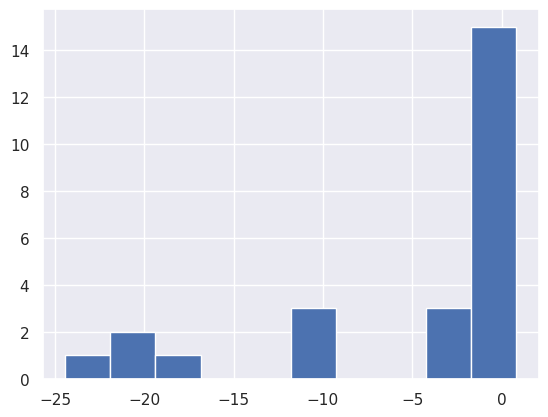

In [254]:
errs = [r2_score(phen_encodings_df[n], phens_df[n]) for n in range(25)]
print(errs)
plt.hist(errs)

[0.779246985912323, 0.7021797299385071, 0.5680339336395264, 0.7983054518699646, 0.7718247175216675, 0.8160886168479919]


(array([1., 0., 0., 1., 0., 1., 0., 0., 3., 8.]),
 array([-18.62163162, -16.80214473, -14.98265784, -13.16317095,
        -11.34368405,  -9.52419716,  -7.70471027,  -5.88522338,
         -4.06573648,  -2.24624959,  -0.4267627 ]),
 <BarContainer object of 10 artists>)

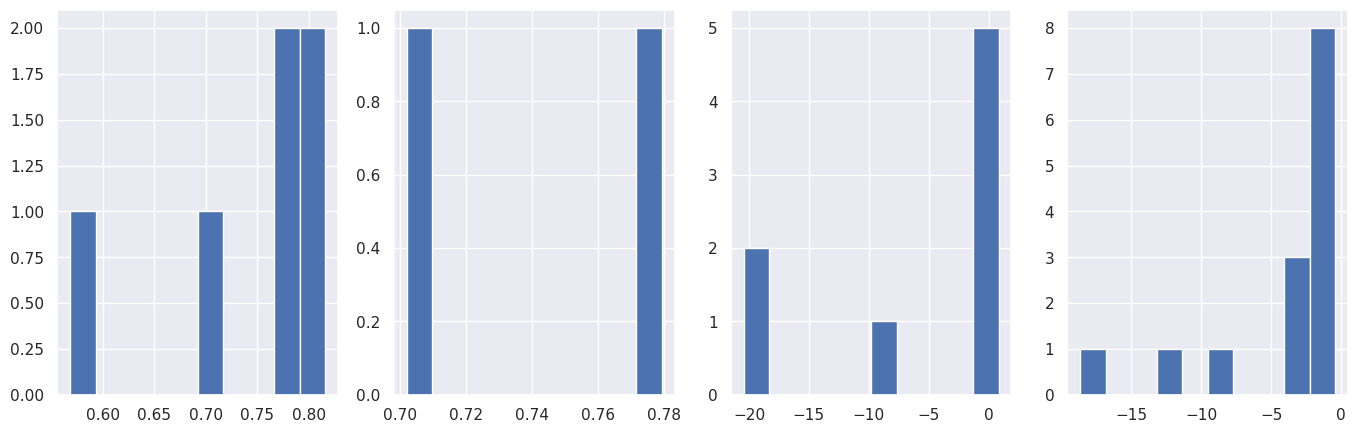

In [255]:
errs = np.array([r2_score(phen_encodings_df[n], phens_df[n]) for n in range(25)])
good_pheno = np.array([0,1,5,7,8,9])

print(list(errs[good_pheno]))

#plt.hist(errs[good_pheno])
plt.figure(figsize=(21, 5))

plt.subplot(1, 5, 1)
plt.hist(errs[good_pheno])

plt.subplot(1, 5, 2)
plt.hist(errs[0:2])

plt.subplot(1, 5, 3)
plt.hist(errs[2:10])

plt.subplot(1, 5, 4)
plt.hist(errs[10:24])

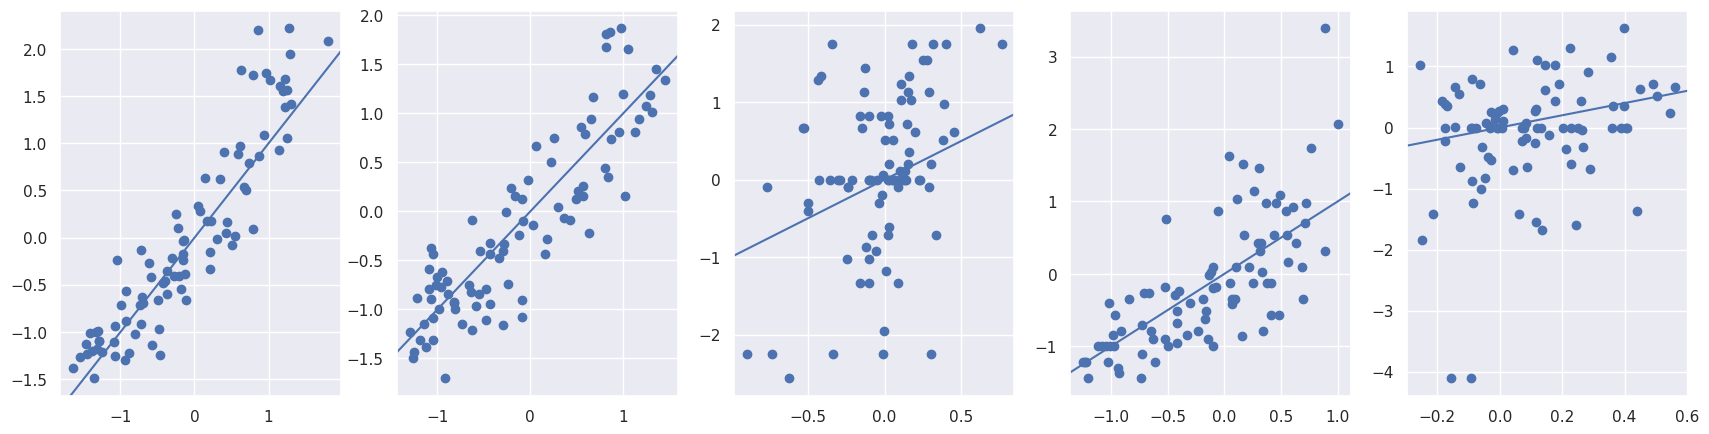

In [256]:
#plt.scatter(phen_encodings_df[1], phens_df[1])


#plot feature ablation importance by predicted feature

plt.figure(figsize=(21, 5))

for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.scatter(phen_encodings_df[i], phens_df[i])
    plt.axline((0, 0), slope=1)


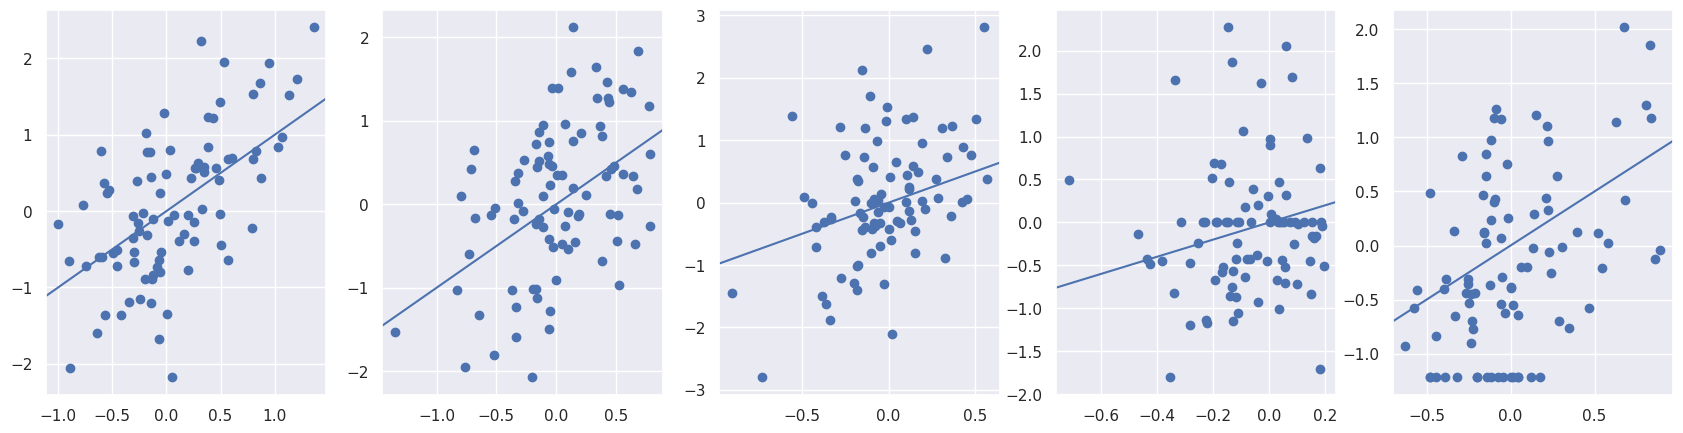

In [257]:
#fitness traits
plt.figure(figsize=(21, 5))

for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.scatter(phen_encodings_df[i+10], phens_df[i+10])
    plt.axline((0, 0), slope=1)

300
0.5252685546875


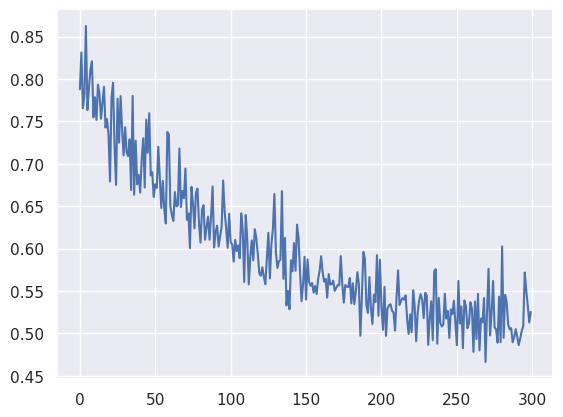

In [258]:
plt.plot(rcon_loss)
print(len(rcon_loss))
print(rcon_loss[-1])

<Axes: >

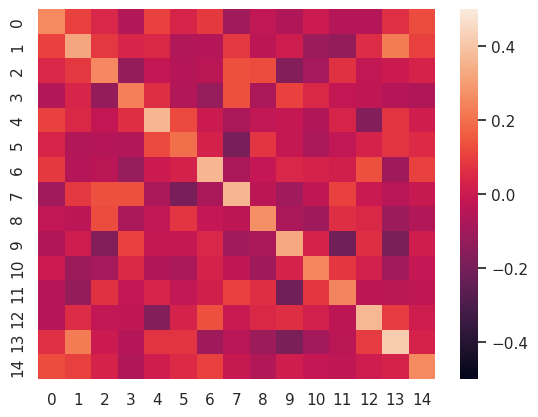

In [259]:

W = P.state_dict()['decoder.0.weight'].cpu()
W_trans = W.T
S = np.log(np.matmul(W_trans, W) + 1)
sns.heatmap(S, vmin=-0.5, vmax=0.5)


In [260]:
#define MSE with no averaging to keep phenotypes loss seperate per phenotype
def sequential_forward_attr_phen_phen(input, phens):
    """puts together two models for use of captum feature importance"""
    mod_2_input = Q(input)
    X_sample = P(mod_2_input)
    output = F.mse_loss(X_sample + EPS, phens[:, :n_phens_pred] + EPS, reduction="none")
    return output


fa_p = FeatureAblation(sequential_forward_attr_phen_phen)


In [261]:
fa_attr = []


for dat in test_loader_pheno:
    ph = dat
    ph = ph.to(device)
    batch_size = ph.shape[0]
    z_sample = Q(ph)
    X_sample = P(z_sample)
    phens += list(ph.detach().cpu().numpy())
    phen_encodings += list(X_sample.detach().cpu().numpy())
    phen_latent += list(z_sample.detach().cpu().numpy())
    fa_attr.append(list(fa_p.attribute(inputs=(ph, ph),perturbations_per_eval = 1)[0].squeeze().detach().cpu().numpy()))

/opt/conda/envs/gpatlas/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [262]:
###########
#iterate over all batches
#change to take mean of batch
df_batch = []
means = []
dfmean = pd.DataFrame()

for sublist in fa_attr: #iterate over each batch
    df_batch = pd.DataFrame(sublist)
    for i in range(5): #iterate over every one of 5 phenotypes
        means = pd.DataFrame(df_batch.iloc[i::5].mean(axis=0)).T #calculate mean importance by averaging over the 30 observations in the batch
        means['input'] = i #column to keep track of which output feature this data relates to
        dfmean = pd.concat([dfmean, means])


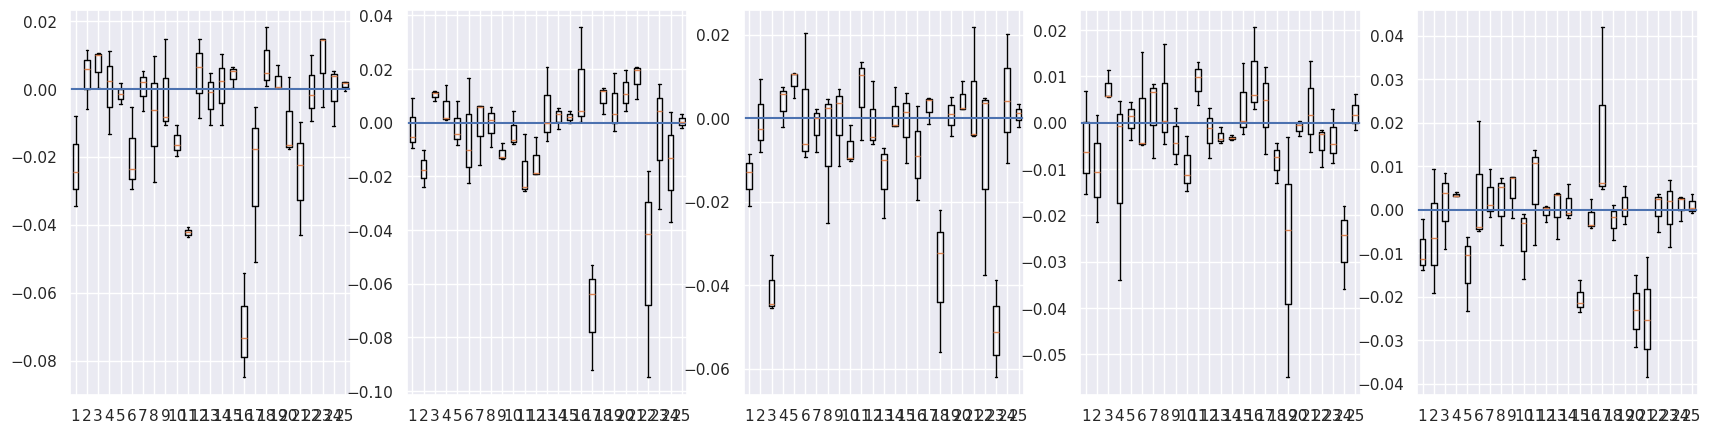

In [263]:
#plot feature ablation importance by predicted feature

plt.figure(figsize=(21, 5))

for i in range(5):
    plt.subplot(1, 5, i+1)
    dfplot = dfmean.loc[dfmean['input'] == i]
    dfplot = dfplot.iloc[:, :-1]
    plt.boxplot(dfplot)
    plt.axhline(y = 0)